## Import required packages

In [1]:
from nltk.corpus import reuters
import nltk
nltk.download('wordnet')
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from yellowbrick.text import TSNEVisualizer
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Getting train and test dataset from nltk reuters corpus

In [2]:
train_documents, train_categories = zip(*[(reuters.raw(i), reuters.categories(i)) for i in reuters.fileids() if i.startswith('training/')])
test_documents, test_categories = zip(*[(reuters.raw(i), reuters.categories(i)) for i in reuters.fileids() if i.startswith('test/')])

In [3]:
print("Number of training documents:", len(train_documents))
print("Number of testing documents:", len(test_documents))

Number of training documents: 7769
Number of testing documents: 3019


# Convert the categorical labels to Multi Label Encodings

In [4]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform(train_categories)
test_labels = mlb.transform(test_categories)

## Creating Dataframe for applying transformations

In [5]:
trainData = {"content": train_documents}
testData = {"content": test_documents}
trainDf = pd.DataFrame(trainData, columns=["content"])
testDf = pd.DataFrame(testData, columns=["content"])

# Pre-process the input data

In [6]:
wordnet_lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stopwords = set(w.rstrip() for w in open("../input/reuters/reuters/reuters/stopwords"))

def tokenize_lemma_stopwords(text):
    text = text.replace("\n", " ")
    tokens = nltk.tokenize.word_tokenize(text.lower()) # split string into words (tokens)
    tokens = [t for t in tokens if t.isalpha()] # keep strings with only alphabets
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens] # put words into base form
    tokens = [stemmer.stem(t) for t in tokens]
    tokens = [t for t in tokens if len(t) > 2] # remove short words, they're probably not useful
    tokens = [t for t in tokens if t not in stopwords] # remove stopwords
    cleanedText = " ".join(tokens)
    return cleanedText

def dataCleaning(df):
    data = df.copy()
    data["content"] = data["content"].apply(tokenize_lemma_stopwords)
    return data

In [7]:
cleanedTrainData = dataCleaning(trainDf)
cleanedTestData = dataCleaning(testDf)

# Create TF-IDF Vectorizer

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

vectorizer = TfidfVectorizer()
vectorised_train_documents = vectorizer.fit_transform(cleanedTrainData["content"])
vectorised_test_documents = vectorizer.transform(cleanedTestData["content"])

# Visualize Word Frequency Distribution

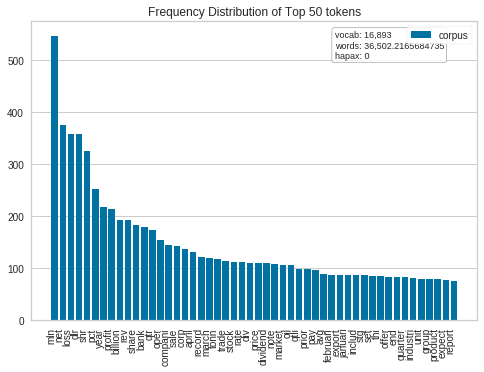

In [9]:
from yellowbrick.text import FreqDistVisualizer
features = vectorizer.get_feature_names()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(vectorised_train_documents)
visualizer.show()

# Visualize the dataset with T-SNE

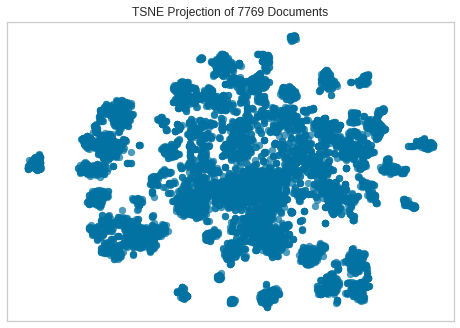

In [10]:
tsne = TSNEVisualizer()
tsne.fit(vectorised_train_documents)
tsne.show()

# Visualizaing corpus with Uniform Manifold Approximation and Projection (UMAP)

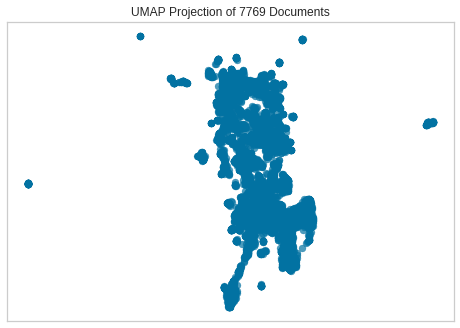

In [11]:
from yellowbrick.text import UMAPVisualizer
from sklearn.cluster import KMeans

umap = UMAPVisualizer(metric="cosine")
umap.fit(vectorised_train_documents)
umap.show()

* This shows high similarity of the documents globally

# Train and Evaluate Classifiers

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss

ModelsPerformance = {}

def metricsReport(modelName, test_labels, predictions):
    accuracy = accuracy_score(test_labels, predictions)

    macro_precision = precision_score(test_labels, predictions, average='macro')
    macro_recall = recall_score(test_labels, predictions, average='macro')
    macro_f1 = f1_score(test_labels, predictions, average='macro')

    micro_precision = precision_score(test_labels, predictions, average='micro')
    micro_recall = recall_score(test_labels, predictions, average='micro')
    micro_f1 = f1_score(test_labels, predictions, average='micro')
    hamLoss = hamming_loss(test_labels, predictions)
    print("------" + modelName + " Model Metrics-----")
    print("Accuracy: {:.4f}\nHamming Loss: {:.4f}\nPrecision:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nRecall:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nF1-measure:\n  - Macro: {:.4f}\n  - Micro: {:.4f}"\
          .format(accuracy, hamLoss, macro_precision, micro_precision, macro_recall, micro_recall, macro_f1, micro_f1))
    ModelsPerformance[modelName] = micro_f1


## KNN Classifier
k-nearest neighbors algorithm (kNN) is a non-parametric technique used for classification.

Given a test document x, the KNN algorithm finds the k nearest neighbors of x among all the
documents in the training set, and scores the category candidates based the class of k neighbors.
The similarity of x and each neighbor’s document could be the score of the category of the neighbor
documents. Multiple KNN documents may belong to the same category; in this case, the summation of
these scores would be the similarity score of class k with respect to the test document x. After sorting
the score values, the algorithm assigns the candidate to the class with the highest score from the test
document x

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

knnClf = KNeighborsClassifier()

knnClf.fit(vectorised_train_documents, train_labels)
knnPredictions = knnClf.predict(vectorised_test_documents)
metricsReport("knn", test_labels, knnPredictions)

------knn Model Metrics-----
Accuracy: 0.3746
Hamming Loss: 0.0106
Precision:
  - Macro: 0.4137
  - Micro: 0.7397
Recall:
  - Macro: 0.1274
  - Micro: 0.3507
F1-measure:
  - Macro: 0.1786
  - Micro: 0.4758


* It seems pretty weak on Multi-label problem

## Decision Tree Classifier
Tree-based methods are simple and useful for interpretation.
A decision tree is a flowchart-like structure in which each internal node represents a "test" on an attribute (e.g. whether a coin flip comes up heads or tails), each branch represents the outcome of the test, and each leaf node represents a class label (decision taken after computing all attributes). The paths from root to leaf represent classification rules.

In [14]:
from sklearn.tree import DecisionTreeClassifier

dtClassifier = DecisionTreeClassifier()
dtClassifier.fit(vectorised_train_documents, train_labels)
dtPreds = dtClassifier.predict(vectorised_test_documents)
metricsReport("Decision Tree", test_labels, dtPreds)

------Decision Tree Model Metrics-----
Accuracy: 0.7469
Hamming Loss: 0.0061
Precision:
  - Macro: 0.4221
  - Micro: 0.7955
Recall:
  - Macro: 0.3302
  - Micro: 0.7503
F1-measure:
  - Macro: 0.3554
  - Micro: 0.7722


* It seems to perform well on overall documents but seems to fail on few classes

## Bagging

* The decision trees suffer from high variance.
* This means that if we split the training data into two parts at random, and fit a decision tree to both halves, the results that we get could be quite different.
* Bootstrap aggregation, or bagging, is a general-purpose procedure for reducing the variance of a statistical learning method; we introduce it here because it is particularly useful and frequently used in the context of decision trees.

In [15]:
from sklearn.ensemble import BaggingClassifier

bagClassifier = OneVsRestClassifier(BaggingClassifier(n_jobs=-1))
bagClassifier.fit(vectorised_train_documents, train_labels)
bagPreds = bagClassifier.predict(vectorised_test_documents)
metricsReport("Bagging", test_labels, bagPreds)

------Bagging Model Metrics-----
Accuracy: 0.7493
Hamming Loss: 0.0041
Precision:
  - Macro: 0.6449
  - Micro: 0.8890
Recall:
  - Macro: 0.4899
  - Micro: 0.8061
F1-measure:
  - Macro: 0.5244
  - Micro: 0.8455


* As you can see here Bagging Classifier gives improved performance over Decision tree in terms of both Macro and Micro averages

## Random Forrest
Random forests provide an improvement over bagged trees by way of a
small tweak that decorrelates the trees. As in bagging, we build a number
of decision trees on bootstrapped training samples. But when building these
decision trees, each time a split in a tree is considered, a random sample of
m predictors is chosen as split candidates from the full set of p predictors.
The split is allowed to use only one of those m predictors. A fresh sample of √m predictors is taken at each split, and typically we choose m ≈ p—that
is, the number of predictors considered at each split is approximately equal
to the square root of the total number of predictors

In other words, in building a random forest, at each split in the tree,
the algorithm is not even allowed to consider a majority of the available
predictors.

In [16]:
from sklearn.ensemble import RandomForestClassifier
rfClassifier = RandomForestClassifier(n_jobs=-1)
rfClassifier.fit(vectorised_train_documents, train_labels)
rfPreds = rfClassifier.predict(vectorised_test_documents)
metricsReport("Random Forest", test_labels, rfPreds)


------Random Forest Model Metrics-----
Accuracy: 0.6320
Hamming Loss: 0.0062
Precision:
  - Macro: 0.4093
  - Micro: 0.9607
Recall:
  - Macro: 0.1120
  - Micro: 0.5748
F1-measure:
  - Macro: 0.1586
  - Micro: 0.7193


* It give average performance on documents but fails miserably on Macro average measure
* Reason for failure in some labels may be due to correlation between features

## Boosting
Recall that bagging involves creating multiple copies of the original train-
ing data set using the bootstrap, fitting a separate decision tree to each
copy, and then combining all of the trees in order to create a single predic-
tive model. Notably, each tree is built on a bootstrap data set, independent
of the other trees. Boosting works in a similar way, except that the trees are
grown sequentially: each tree is grown using information from previously
grown trees. Boosting does not involve bootstrap sampling; instead each
tree is fit on a modified version of the original data set.

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

boostClassifier = OneVsRestClassifier(GradientBoostingClassifier())
boostClassifier.fit(vectorised_train_documents, train_labels)
boostPreds = boostClassifier.predict(vectorised_test_documents)
metricsReport("Boosting", test_labels, boostPreds)


------Boosting Model Metrics-----
Accuracy: 0.7443
Hamming Loss: 0.0042
Precision:
  - Macro: 0.5750
  - Micro: 0.8817
Recall:
  - Macro: 0.5049
  - Micro: 0.8005
F1-measure:
  - Macro: 0.5180
  - Micro: 0.8391


* It performs as good as Bagging Classifier

## Naive Bayes Classifier

Naive Bayes Classifier (NBC) is generative model which is widely used in Information Retrieval.
The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [18]:
from sklearn.naive_bayes import MultinomialNB

nbClassifier = OneVsRestClassifier(MultinomialNB())
nbClassifier.fit(vectorised_train_documents, train_labels)

nbPreds = nbClassifier.predict(vectorised_test_documents)
metricsReport("Multinomial NB", test_labels, nbPreds)

------Multinomial NB Model Metrics-----
Accuracy: 0.4462
Hamming Loss: 0.0088
Precision:
  - Macro: 0.0555
  - Micro: 0.9949
Recall:
  - Macro: 0.0178
  - Micro: 0.3654
F1-measure:
  - Macro: 0.0222
  - Micro: 0.5345


* MultinomialNB performance is poor. There may be correlation between features. MultinomialNB is highly sensitive to that

## Support Vector Machine (Linear SVC)
* Support Vector Machine (SVM), an approach for classification that was developed in the computer science community in
the 1990s and that has grown in popularity since then. 
* SVMs have been shown to perform well in a variety of settings, and are often considered one of the best “out of the box” classifiers.
* The support vector machine is a generalization of a simple and intuitive classifier called the maximal margin classifier

In [19]:
from sklearn.svm import LinearSVC

svmClassifier = OneVsRestClassifier(LinearSVC(), n_jobs=-1)
svmClassifier.fit(vectorised_train_documents, train_labels)

svmPreds = svmClassifier.predict(vectorised_test_documents)
metricsReport("SVC Sq. Hinge Loss", test_labels, svmPreds)

------SVC Sq. Hinge Loss Model Metrics-----
Accuracy: 0.8115
Hamming Loss: 0.0034
Precision:
  - Macro: 0.6487
  - Micro: 0.9445
Recall:
  - Macro: 0.3964
  - Micro: 0.8007
F1-measure:
  - Macro: 0.4682
  - Micro: 0.8667


* Linear SVC with Squarred hinge loss seems to outperfom all the previously seen models
* SVCs are much more robust against Correlated features

In [20]:
from skmultilearn.problem_transform import LabelPowerset

powerSetSVC = LabelPowerset(LinearSVC())
powerSetSVC.fit(vectorised_train_documents, train_labels)

powerSetSVCPreds = powerSetSVC.predict(vectorised_test_documents)
metricsReport("Power Set SVC", test_labels, powerSetSVCPreds)

------Power Set SVC Model Metrics-----
Accuracy: 0.8420
Hamming Loss: 0.0036
Precision:
  - Macro: 0.6871
  - Micro: 0.9038
Recall:
  - Macro: 0.4788
  - Micro: 0.8256
F1-measure:
  - Macro: 0.5289
  - Micro: 0.8629


# Comparison on different models based on their Micro-F1 score

In [21]:
print("  Model Name " + " "*10 + "| Micro-F1 Score")
print("-------------------------------------------")
for key, value in ModelsPerformance.items():
    print("  " + key, " "*(20-len(key)) + "|", value)
    print("-------------------------------------------")

  Model Name           | Micro-F1 Score
-------------------------------------------
  knn                  | 0.4758108352962493
-------------------------------------------
  Decision Tree        | 0.772233676975945
-------------------------------------------
  Bagging              | 0.8454965681467993
-------------------------------------------
  Random Forest        | 0.7192513368983957
-------------------------------------------
  Boosting             | 0.8391432171356573
-------------------------------------------
  Multinomial NB       | 0.5344793905059582
-------------------------------------------
  SVC Sq. Hinge Loss   | 0.8667244868459092
-------------------------------------------
  Power Set SVC        | 0.862925739810162
-------------------------------------------


## Lets's look at the classification report for LinearSVC Classifier(best so far)

In [22]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, svmPreds))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       719
           1       1.00      0.48      0.65        23
           2       1.00      0.64      0.78        14
           3       0.87      0.67      0.75        30
           4       0.88      0.39      0.54        18
           5       0.00      0.00      0.00         1
           6       1.00      0.94      0.97        18
           7       1.00      0.50      0.67         2
           8       0.00      0.00      0.00         3
           9       0.96      0.96      0.96        28
          10       1.00      0.78      0.88        18
          11       0.00      0.00      0.00         1
          12       0.96      0.79      0.86        56
          13       1.00      0.55      0.71        20
          14       0.00      0.00      0.00         2
          15       0.93      0.46      0.62        28
          16       0.00      0.00      0.00         1
          17       0.89    

## Things we have done so far:
* Here We have compared various Machine learning based classifiers for Multi-label text classification with TF-IDF feature extraction
* We also have used inherent multi-label Classifiers like Random-Forest, Decision Tree, Knn and also used various methods like OneVsRest and Label Power Set

## Next Steps:
* Use Word Embeddings
* Deep learning based approaches (RNNs, CNNs, Transformers)